# Learning about the Global Warming Potential through Programming - Understanding by Quantifying and Playing

## by Mike Müller

`jupyter nbconvert foo.ipynb --to slides --post serve`


In [70]:
from pathlib import Path

rcp_scenarios = {
    'RCP 2.6': 'RCP3PD_EMISSIONS.csv',
    'RCP 4.5': 'RCP45_EMISSIONS.csv',
    'RCP 6': 'RCP6_EMISSIONS.csv',
    'RCP 8.5': 'RCP85_EMISSIONS.csv',
}
base_path = Path('/Users/mike/projekte/Ernährung/climate_costs/co2-warming-equivalence/RCPdata')

for name, path in rcp_scenarios.items():
    rcp_scenarios[name] = base_path / path
    


## Climate Change - Global Warming

* Human impact on our climate
* Increases the (necessary) greenhouse effect
* Greenhouse gases (GHG)

    + Water vapor and clouds (36 - 72%)
    + Carbon dioxide ($CO_2$) from burning fossil fuels and land use (9 - 26%)
    + Methane from oil and natural gas production, bogs and swamps, agriculture  (4 - 9%)
    + Nitrous oxide ($N_2O$) from Nitrogen fertilizing
    + Many more (35 substances, Ozone, CFC, HCFC), example: air condition fluids
    
percentages from https://en.wikipedia.org/wiki/Greenhouse_gas

## Focus on Carbon dioxide ($CO_2$) and Methane ($CH_4$)

* $CO_2$ - long-lived climate pollutant (LLCP)

    + atmospheric lifetime of 100s to 1,000s of years
    
* $CH_4$ - short lived climate pollutant (SLCP)
 
    + atmospheric lifetime of 12 ± 3 years



## RCP - Representative Concentration Pathways

* Historical data plus projections from 1765 to 2300
* Combination of several estimates for historical emissions
* Plus 4 different Integrated Assessment Models

Radiative forcing  [$W/m_2$] | Explanation
-----------------------------|------------------------ 
2.6                          |  strong mitigation scenario, net_zero $CO_2$ by 2100 temperature increase < 2K
4.5                          |  temperature increase 2 - 3 K by 2100
6.0                          |  emissions peak around 2080, then decline
8.5                          | "business as usual" - worst case scenario, temperature increase 4.5 K by 2100

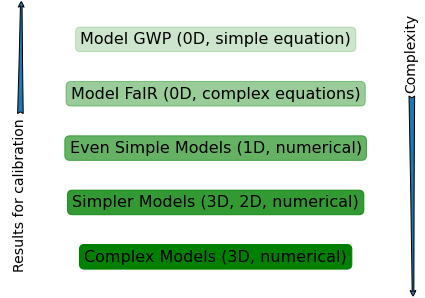

In [71]:
from functools import partial
from matplotlib import pyplot as plt


def main_box(text, x=0.5, y=0, 
             background_color='green',
             edge_color=None,
             alpha=1, ):
    if edge_color is None:
        edge_color = background_color
    plt.text(x, y, text, size=16, 
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       alpha=alpha, 
                       ec=edge_color,
                       fc=background_color,
                       )
             )
    
main_box('Complex Models (3D, numerical)')
main_box('Simpler Models (3D, 2D, numerical)', y=0.25, alpha=0.8)
main_box('Even Simple Models (1D, numerical)', y=0.5, alpha=0.6)
main_box('Model FaIR (0D, complex equations)', y=0.75, alpha=0.4)
main_box('Model GWP (0D, simple equation)', y=1, alpha=0.2)
ax = plt.gca()
#ax.set_title('Types of Climate Models')
ax.set_axis_off()
arrowprops = dict(arrowstyle='fancy')
ax.annotate("Results for calibration", xy=(0.05, 1), xytext=(0.03, 0.1),
            arrowprops=arrowprops,
            rotation=90,
            fontsize=14,
            xycoords='figure fraction',
            textcoords='figure fraction')
ax.annotate("Complexity",
            xy=(0.97, 0), 
            xytext=(0.95, 0.7),
            arrowprops=arrowprops,
            rotation=90,
            fontsize=14,
            xycoords='figure fraction',
            textcoords='figure fraction')
plt.savefig('model_types.png')

## Types of Climate Models

![Image](model_types.png)

## Simulate Temperature with FaIR

* Finite Amplitude Impulse-Response simple climate-carbon-cycle model
* Calculate past and projected temperature increase caused by Methane **only**

In [72]:
import numpy as np

from fair.forward import fair_scm
from fair.RCPs import rcp26, rcp45, rcp6, rcp85


def calc_temp_increase():
    forcings = {
        'RCP 2.6': rcp26.Forcing.forcing,
        'RCP 4.5': rcp45.Forcing.forcing,
        'RCP 6': rcp6.Forcing.forcing, 
        'RCP 8.5': rcp85.Forcing.forcing
    }

    temps = {}
    for name, forcing in forcings.items():
        noco2 = np.zeros_like(forcing[:, 9])
        *_, temp = fair_scm(useMultigas=False, emissions=noco2, other_rf=forcing[:,9] * 1.65)
        temps[name] = temp
    temperature_increases = pd.DataFrame(temps)
    temperature_increases .index = forcing[:, 0]
    return temperature_increases

## Greenhouse Warming Potential (GWP)

* Normalization to a time period of 20, 100, or 500 years

Gas    | $GWP_{20}$ | $GWP_{100}$ | $GWP_{500}$
-------|------------|-------------|----------- 
$CO_2$ |  1         | 1           | 1
$CH_4$ | 84         | 28          | 7.6

* Carbon dioxide equivalent $CO_2\mbox{-}e$ (sometimes $CO_2\mbox{-}C_{eq}$)

* Most used is $GWP_{100}$ 
* Therefore, we focus on this

## Problems with GWP

* Deeply embedded in climate policy
* But leads to wrong conclusions:

    + Falling SLCP emissions lead to **falling** global temperatures
    + GWP-based calculations show **raising** global temperatures
    
* Complex, physical-based climate models confirm this
* Much simpler tools like GWP are very useful because complex models are very resource-intensive
    

## GWP* and  $CO_2\mbox{-}e$ 

* Emissions based on GWP: 

$E_{CO_2\mbox{-}e} = E_{SLCP} * GWP_H$ 
    

* Emissions based on GWP*: 

$E_{CO_2\mbox{-}e*} = \frac{\Delta E_{SLCP}} {\Delta t} * GWP_H$ * H

## Reading data with pandas

In [73]:
import pandas as pd

def read_data(file_name, sep = ',', skiprows=36, index_col=0, species='CH4', 
              unit_converter=0.001):
    """"""
    data = pd.read_csv(file_name, sep=sep, skiprows=skiprows, index_col=index_col)
    return data[species] * unit_converter

## Calculate GWP*

In [74]:
GWP100_CH4 = 28

def calc_gwpstar_emissions(emissons, gwp_h=GWP100_CH4, h=100, delt=20):
    """    
    Calculation of GWP* from GWP 
    
    Based on Allen et. al 2018
    
    :param: emissons pandas Series with emission values, index is year
    :param: gwp_h GWP for `h` years
    :param: h time in years 
    :param: delt delta tine in years
    :return: GWP*  
    """
    emissons_0 = emissons.iloc[:-delt]
    emissons_1 = emissons.iloc[delt:]
    emissons_1.index = emissons_0.index  # assume pandas Series
    return ((emissons_1 - emissons_0) / delt) * gwp_h * h

## Compute GWP and GWP* in a DataFrane

In [75]:
def make_gwp_df(file_name, start_year=1765, end_year=2500, base_year=1765):
    emissons = read_data(file_name)
    start_index = start_year - base_year
    end_index = end_year - base_year + 1
    e_co2_eq = (emissons * GWP100_CH4)[start_index:end_index]
    e_co2_eq_star = calc_gwpstar_emissions(emissons)[start_index:end_index]
    e_co2_eq.name = '$CH_4$ GWP'
    e_co2_eq_star.name = '$CH_4$ GWP*'
    df = pd.DataFrame([e_co2_eq, e_co2_eq_star]).T
    df.index.name = 'Years'
    return df

## Plot

In [76]:
from matplotlib import pyplot as plt

def plot_one(ax, name, path, make_df, temp_increases):
    start_year=1900
    end_year=2100
    df = make_df(path, start_year=start_year, end_year=end_year)
    ax1 = df.cumsum().plot(ax=ax, title=name, legend=None)
    ax2 = ax1.twinx()
    ax2.set_ylim((0, 1))
    temp_increases[start_year:end_year].plot(ax=ax2, color='black', style='--', 
                                             label='temperature increase [K]')
    return ax1, ax2
    
def plot_all(rcp_scenarios,  make_df=make_gwp_df):
    temperatures = calc_temp_increase()
    fig, subs = plt.subplots(2, 2)
    fig.set_size_inches(10, 5)
    subs_flat = subs.flat
    for name, path in rcp_scenarios.items():
        sub = next(subs_flat)
        ax1, ax2 = plot_one(sub, name, path, make_df=make_df, 
                            temp_increases=temperatures[name])
    ax1.legend(loc=(1.2, 0))
    ax2.legend(loc=(1.2, 0.6))
    fig.text(0.75, 0.5, 'temperature increase [K]', rotation='vertical')
    fig.text(-0.01, 0.25, 'Emissions [$GtCO_2e$ or $GtCO_2e*$ / year]', rotation='vertical')
    fig.tight_layout()

## Plot all

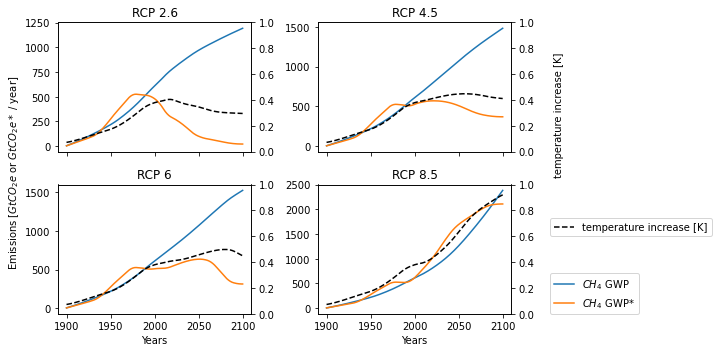

In [77]:
plot_all(rcp_scenarios, make_df=make_gwp_df)

## GWP* improved 

$E_{CO_2\mbox{-}we*} = [r * \frac{\Delta E_{SLCP}} {\Delta t} * H + s *  E_{SLCP}] * GWP_H$


### Flow term - Response to emission rate

$r * \frac{\Delta E_{SLCP}} {\Delta t} * GWP_H$

### Stock term - Long-term equilibration to past increase in forcing (memory)

$s *  E_{SLCP} * GWP_H$ 


* Linear regression: r = 0.75, s = 0.25

## Calculate modified GWP* too

In [78]:
def make_gwp_df_mod(file_name, start_year=1765, end_year=2500, base_year=1765, r=0.75, s=0.25):
    emissons = read_data(file_name)
    start_index = start_year - base_year
    end_index = end_year - base_year + 1
    e_co2_eq = (emissons * GWP100_CH4)[start_index:end_index]
    e_co2_eq_star = calc_gwpstar_emissions(emissons)[start_index:end_index]
    # here's the meat
    e_co2_eq_star_mod = r * e_co2_eq_star + s * e_co2_eq
    e_co2_eq.name = '$CH_4$ GWP'
    e_co2_eq_star.name = '$CH_4$ GWP* flow only'
    e_co2_eq_star_mod.name = '$CH_4$ GWP* flow and stock'
    
    df = pd.DataFrame([e_co2_eq, e_co2_eq_star, e_co2_eq_star_mod]).T
    df.index.name = 'Years'
    return df

## Plot again

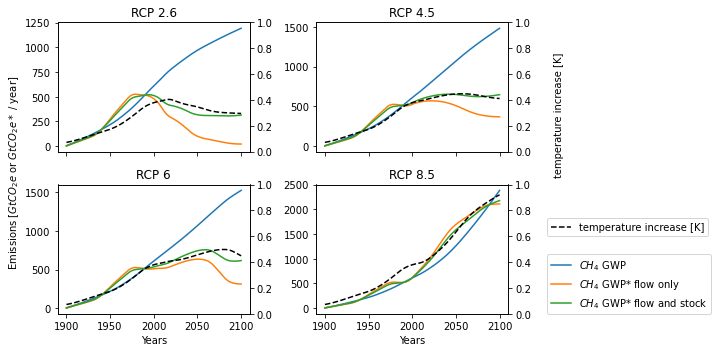

In [79]:
plot_all(rcp_scenarios, make_df=make_gwp_df_mod)

## Conclusions

* Quantification  with Python programming can help to understand how climate modeling works
* Many open source tools available
* Often code is very "result-oriented", lacking basic sw engineering principles
* Improving this code can help improve scientific outcome